In [1]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
import pandas, xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from matplotlib import pyplot
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
tqdm_notebook.pandas()
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import layers, models, optimizers, Sequential
from sklearn.decomposition import TruncatedSVD
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from keras_tqdm import TQDMNotebookCallback
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.
C:\Users\Sabir Ismail\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pandas as pd
df_temp = pd.read_csv('../Data/all_combined.csv')
print(len(df_temp))
df_temp.head()

237046


,Unnamed: 0,state,id,link,county,newspaper,date,content,notice_id,category,...,Fictitious Business Names (DBA),Water Resumes,Tax Deeds,Seizures,Forfeited Property,Estate Claims,count_catogory,category_no_duplicate,category_no_duplicate_str,count_catogory_no_duplicate
0,0,Mississippi,626/2272017_23983816,http://www.publicnoticeads.com/MS/search/view....,Pearl River,Picayune Item,2017/02/24,"notice of auction on friday, march 17, 2017 a...",23983816.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1
1,1,Mississippi,626/2272017_23983815,http://www.publicnoticeads.com/MS/search/view....,Pearl River,Picayune Item,2017/02/24,"public notice on october 28, 2015, the pa sta...",23983815.0,['License Suspension'],...,False,False,False,False,False,False,1,['License Suspension'],['License Suspension'],1
2,6,Louisiana,346/2242017_23980782,http://www.publicnoticeads.com/LA/search/view....,Lincoln,The Ruston Daily Leader,2017/02/24,february 24 legals notice of special elec...,23980782.0,['Elections'],...,False,False,False,False,False,False,1,['Elections'],['Elections'],1
3,17,Louisiana,363/3012017_23987556,http://www.publicnoticeads.com/LA/search/view....,St. Bernard,The St. Bernard Voice,2017/02/24,sheriff's sales bank of america na vs. katedra...,23987556.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1
4,20,Louisiana,363/3012017_23987557,http://www.publicnoticeads.com/LA/search/view....,St. Bernard,The St. Bernard Voice,2017/02/24,sheriff's sales gulf coast bank and trust co v...,23987557.0,['Auctions'],...,False,False,False,False,False,False,1,['Auctions'],['Auctions'],1


In [3]:
df_temp = df_temp[['content', 'category_no_duplicate']]

In [4]:
df_temp = df_temp.rename(columns={'category_no_duplicate': 'category'})

<Figure size 576x432 with 0 Axes>

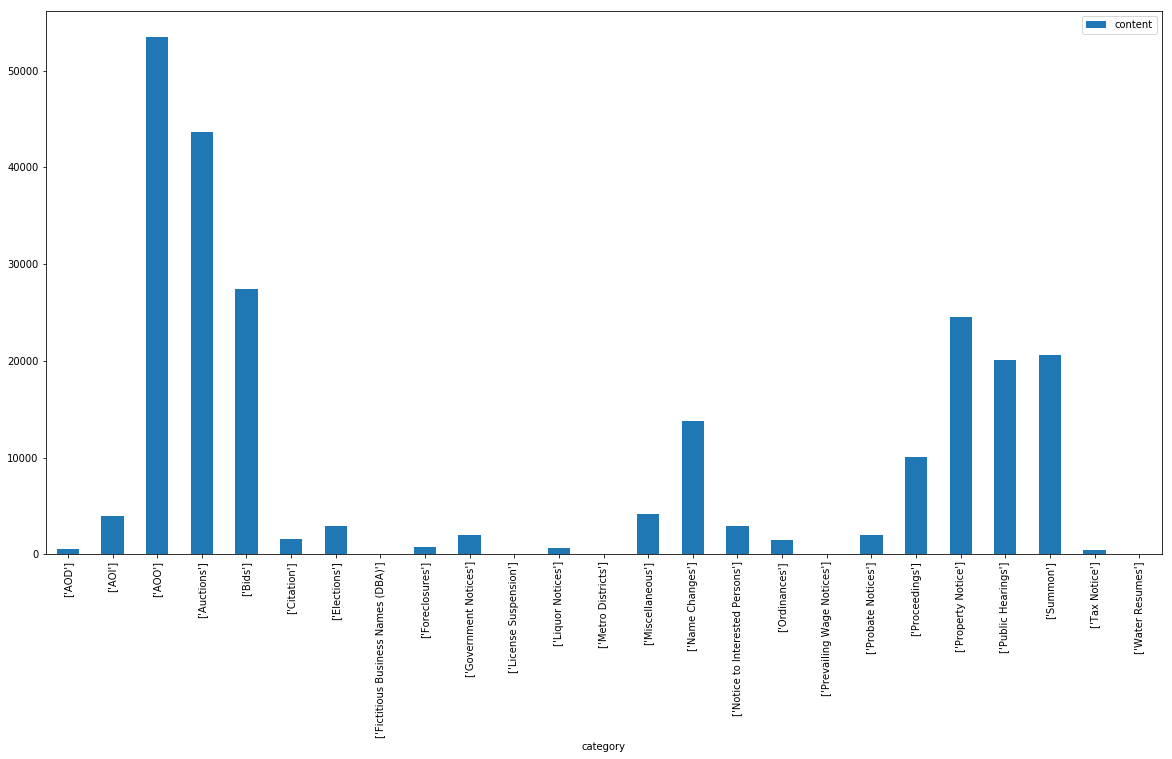

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_temp.groupby('category').count().plot.bar(ylim=0, figsize=(20,10))
plt.show()

In [8]:
#creating a function to encapsulate preprocessing, to mkae it easy to replicate on  submission data
def processing(df):
    df['content'] = df['content'].apply(lambda x: re.sub(r'[^\w\s]','', x.lower()))
    return(df)

In [9]:
df_temp = processing(df_temp)
df_temp.head()

,content,category
0,notice of auction on friday march 17 2017 at ...,['Auctions']
1,public notice on october 28 2015 the pa state...,['License Suspension']
2,february 24 legals notice of special elec...,['Elections']
3,sheriffs sales bank of america na vs katedra g...,['Auctions']
4,sheriffs sales gulf coast bank and trust co vs...,['Auctions']


In [27]:
X_data['content'] = df_temp['content'].astype(str)
y_data['category'] = df_temp['category']

In [28]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [29]:
X_data.head()

0    notice of auction  on friday march 17 2017 at ...
1    public notice  on october 28 2015 the pa state...
2    february 24 legals      notice of special elec...
3    sheriffs sales bank of america na vs katedra g...
4    sheriffs sales gulf coast bank and trust co vs...
Name: content, dtype: object

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

Post = Pipeline([
                ('selector', TextSelector(key='content')),
                #('cnt', CountVectorizer(stop_words='english'))
                ('tf_idf', TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')),
            ])

Post.fit_transform(X_data)

<237047x465479 sparse matrix of type '<class 'numpy.float64'>'
	with 32016732 stored elements in Compressed Sparse Row format>

In [38]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion([('Post', Post)])
                      
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_data)

<237047x465479 sparse matrix of type '<class 'numpy.float64'>'
	with 32016732 stored elements in Compressed Sparse Row format>

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, random_state=42)

In [44]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(177785,)
(59262,)
(177785,)
(59262,)


In [47]:
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

print(X_train.shape)
print(y_train.shape)

pipeline.fit(X_train, y_train)

(177785,)
(177785,)


ValueError: Found input variables with inconsistent numbers of samples: [237047, 177785]

In [ ]:
preds = pipeline.predict(X_test)
score = np.mean(preds == y_test)
print(score)